In [ ]:
import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from datetime import timedelta

from config import *
from data.util import crop_q_between, count_points_in_period
from plot.util import plot_trend_and_fft

%reload_ext autoreload
%autoreload 2

In [2]:
SECTION = 160

Load matrix $Q$

In [3]:
mat_q = CONFIG.load('mat_q_nonzero.pt')
mat_q.shape

torch.Size([35040, 357])

torch.Size([35040, 357])


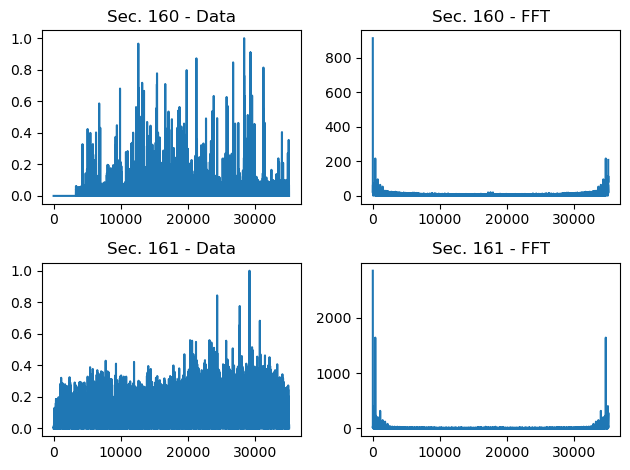

In [4]:
mat_q_fft = torch.fft.fft(mat_q, dim=0)
mat_q_fft_mag = torch.abs(mat_q_fft)
print(mat_q_fft.shape)

plot_trend_and_fft(mat_q, mat_q_fft_mag, n_plots=2, start_sec=SECTION)

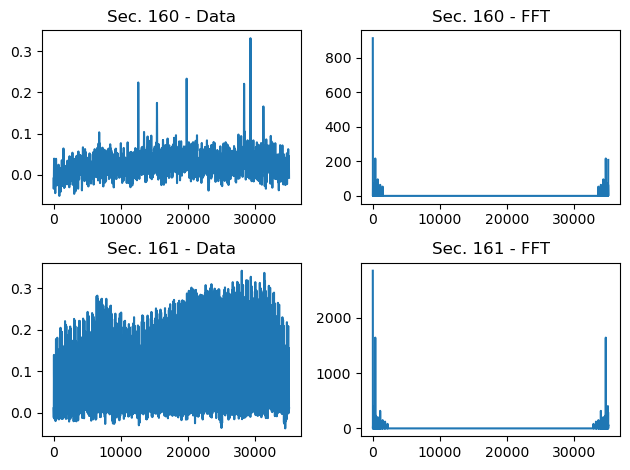

In [5]:
mat_q_trend_fft = mat_q_fft.clone()
mat_q_trend_fft[mat_q_fft_mag < 40] = 0.0
mat_q_trend_fft_mag = torch.abs(mat_q_trend_fft)

mat_q_trend = torch.fft.ifft(mat_q_trend_fft, dim=0)
CONFIG.save(mat_q_trend, 'mat_q_trend.pt')

plot_trend_and_fft(torch.real(mat_q_trend), mat_q_trend_fft_mag, n_plots=2, start_sec=SECTION)

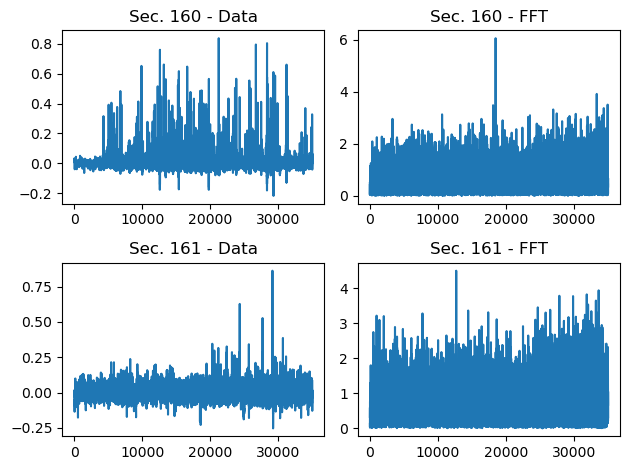

In [6]:
mat_q_resid = mat_q - mat_q_trend
CONFIG.save(mat_q_resid, 'mat_q_resid.pt')

mat_q_resid_fft_mag = torch.abs(torch.fft.fft(mat_q_resid, dim=1))

plot_trend_and_fft(torch.real(mat_q_resid), mat_q_resid_fft_mag, n_plots=2, start_sec=SECTION)

/tmp/ipykernel_12478/1325936498.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gridspec.tight_layout(fig)


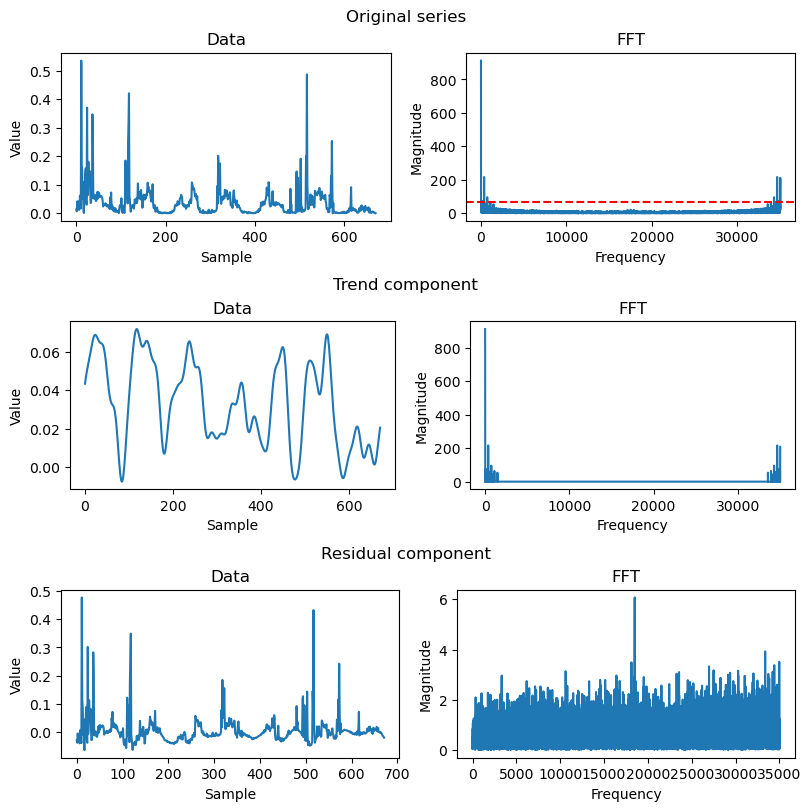

In [7]:
plot_period = CONFIG.test_period
xaxis = torch.arange(count_points_in_period(plot_period))

fig = plt.figure(constrained_layout=True, figsize=(8, 8))
gridspec = gs.GridSpec(nrows=3, ncols=1, figure=fig)

def plot(data, axis):
    axis.plot(data[:, SECTION].cpu())


def plot_data(data, row, axis):
    data = crop_q_between(data, CONFIG.read_period, plot_period)
    plot(data, axis)
    axis.set_title('Data')
    axis.set_xlabel('Sample')
    axis.set_ylabel('Value')


def plot_fft(data, row, axis, plot_P):
    plot(data, axis)
    axis.set_title('FFT')
    axis.set_xlabel('Frequency')
    axis.set_ylabel('Magnitude')
    if plot_P:
        axis.axhline(y=70, linestyle='--', color='r')


def plot_row(data, fft, row, title, plot_P=False):
    subfig = fig.add_subfigure(gridspec[row])
    subfig.suptitle(title)
    axes = subfig.subplots(ncols=2)
    plot_data(data, row, axes[0])
    plot_fft(fft, row, axes[1], plot_P=plot_P)


plot_row(mat_q, mat_q_fft_mag, 0, 'Original series', plot_P=True)
plot_row(mat_q_trend.real, mat_q_trend_fft_mag, 1, 'Trend component')
plot_row(mat_q_resid.real, mat_q_resid_fft_mag, 2, 'Residual component')

gridspec.tight_layout(fig)